In [235]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [236]:
FIRST_SIZE = 2
STEP_SIZE = 8
LAST_SIZE = 256 + 1 + FIRST_SIZE

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [237]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [238]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [239]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    is_numpy: bool = True
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)

    alpha_old = None

    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

In [240]:
def calc_LU(original: np.matrix) -> tuple[np.matrix, np.matrix]:
    matrixU = np.matrix(np.zeros(original.shape))
    matrixU[0] = original[0]

    matrixL = np.diag(np.ones((original.shape[0])))
    for i in range(original.shape[1]):
        matrixL[i, 0] = original[i, 0] / original[0, 0]

    for row in range(1, original.shape[0]):
        for column in range(1, original.shape[1]):
            if row <= column:
                elem_sum = sum(
                    matrixL[row, i] * matrixU[i, column] for i in range(0, row - 1 + 1)
                )
                matrixU[row, column] = original[row, column] - elem_sum
                continue
            elem_sum = sum(
                matrixL[row, i] * matrixU[i, column] for i in range(0, column - 1 + 1)
            )
            matrixL[row, column] = (original[row, column] - elem_sum) / matrixU[
                column, column
            ]
    return matrixL, matrixU


def get_inverse_LU(matrix):
    ML, MU = calc_LU(matrix)
    out_mt = np.zeros(matrix.shape)
    for iter in range(matrix.shape[0]):
        b = np.zeros((matrix.shape[0], 1))
        b[iter] = 1
        y = np.linalg.solve(ML, b)
        x = np.linalg.solve(MU, y)
        x = x.reshape((1, matrix.shape[0]))
        out_mt[:, iter] = x
    return out_mt


def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    is_numpy: bool = True,
) -> np.matrix:
    try:
        if is_numpy:
            inv_A = np.linalg.inv(A)
        else:
            inv_A = get_inverse_LU(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    res = power_iteration(
        A=inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [241]:
A: np.matrix = np.matrix("1 3 -2 0;"
                         "1 1 4 7;"
                         "4 7 11 23;"
                         "52 66 2 0")  # -0.65
eigvec, eigval = inverse_power_def(A)
calc(A, eigvec), eigval

(-0.6514125115723834, -0.6514276562641111)

# Тестирование

## Подготовка

In [242]:
def output(
    A: np.matrix,
    funcs_names: list[str],
    funcs: list,
    is_numpy: bool = True,
    num_iterations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> tuple[np.matrix, list[float | None]]:

    eigs = np.linalg.eigvals(A)
    if any(isinstance(eig, np.complex128) for eig in eigs):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)

    mass_eval = []

    for func_name, f in zip(funcs_names, funcs):
        start_time = time()
        evec, eval = f(A=A, b_k=b_k, num_iterations=num_iterations, is_numpy=is_numpy)
        stop_time = time()
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)

    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [243]:
def generate_non_singular(n):
    while True:
        matrix = np.random.rand(n, n)
        if np.linalg.det(matrix) != 0:
            return matrix

In [244]:
funcs_names = ["Прямые итерации", "Обратные итерации (обычные)"]
funcs = [power_iteration, inverse_power_def]

## Тестирование на заранее заготовленных матрицах

In [245]:
A = np.array([[11, 2, 5], [2, 7, 3], [5, 3, 11]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(17.22753579693707),
 17.22753326602281,
 np.float64(5.209270633258371),
 5.212708356776365)

In [246]:
A = np.array([[17, -3, 7], [-3, 22, 8], [7, 8, 11]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(26.266048432199927),
 26.265892098144025,
 np.float64(2.7443535938170776),
 2.7443548451696227)

In [247]:
A = np.array([[1, 2, 4], [4, 5, 6], [7, 8, 9]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(16.503789400306477),
 16.50379165898621,
 np.float64(0.11246753586075879),
 0.11246745942971054)

## Тестирование на случайных симметричных матрицах

Симметричные матрицы необходимы для вещественных корней

In [248]:
for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # Пришлось ввести симметричную матрицу из-за комплексных корней
        df.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(A=matr, funcs_names=funcs_names, funcs=funcs, is_numpy=False)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])

res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def"]]

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:10
1
2
3
4
5
6
7
8
9
10

Current size:18
1
2
3
4
5
6
7
8
9
10

Current size:26
1
2
3
4
5
6
7
8
9
10

Current size:34
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:50
1
2
3
4
5
6
7
8
9
10

Current size:58
1
2
3
4
5
6
7
8
9
10

Current size:66
1
2
3
4
5
6
7
8
9
10

Current size:74
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:90
1
2
3
4
5
6
7
8
9
10

Current size:98
1
2
3
4
5
6
7
8
9
10

Current size:106
1
2
3
4
5
6
7
8
9
10

Current size:114
1
2
3
4
5
6
7
8
9
10

Current size:122
1
2
3
4
5
6
7
8
9
10

Current size:130
1
2
3
4
5
6
7
8
9
10

Current size:138
1
2
3
4
5
6
7
8
9
10

Current size:146
1
2
3
4
5
6
7
8
9
10

Current size:154
1
2
3
4
5
6
7
8
9
10

Current size:162
1
2
3
4
5
6
7
8
9
10

Current size:170
1
2
3
4
5
6
7
8
9
10

Current size:178
1
2
3
4
5
6
7
8
9
10

Current size:186
1
2
3
4
5
6
7
8
9
10

Current size:194
1
2
3
4
5
6
7
8
9
10

Current size:202
1
2
3
4
5
6
7
8
9
10



,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,1.516786,0.035725,1.516786,0.0,0.035725,0.001001,0.0,0.0
2,2,0.649416,0.036611,0.649416,0.0,0.036611,0.0,0.0,0.0
3,2,0.260801,0.000384,0.260801,0.0,0.000384,0.000999,0.0,0.0
4,2,1.674606,0.233573,1.674606,0.0,0.233573,0.0,0.0,0.0
5,2,0.937705,0.246074,0.937701,0.0,0.246074,0.001,0.000004,0.0
...,...,...,...,...,...,...,...,...,...
326,258,16661.326448,0.000744,16661.326448,0.0,0.000744,4.182779,0.0,0.0
327,258,16748.940089,0.001177,16748.940089,0.0,0.001177,4.287638,0.0,0.0
328,258,16611.824211,0.000121,16611.824211,0.0,0.000121,4.253646,0.0,0.0
329,258,16627.185583,0.000173,16627.185583,0.0,0.000173,4.304613,0.0,0.0


In [249]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,1.516786,0.035725,1.516786,0.0,0.035725,0.001001,0.0,0.0
2,2,0.649416,0.036611,0.649416,0.0,0.036611,0.0,0.0,0.0
3,2,0.260801,0.000384,0.260801,0.0,0.000384,0.000999,0.0,0.0
4,2,1.674606,0.233573,1.674606,0.0,0.233573,0.0,0.0,0.0
5,2,0.937705,0.246074,0.937701,0.0,0.246074,0.001,0.000004,0.0
...,...,...,...,...,...,...,...,...,...
326,258,16661.326448,0.000744,16661.326448,0.0,0.000744,4.182779,0.0,0.0
327,258,16748.940089,0.001177,16748.940089,0.0,0.001177,4.287638,0.0,0.0
328,258,16611.824211,0.000121,16611.824211,0.0,0.000121,4.253646,0.0,0.0
329,258,16627.185583,0.000173,16627.185583,0.0,0.000173,4.304613,0.0,0.0


In [250]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
5,2,0.937705,0.246074,0.937701,0.0,0.246074,0.001,0.000004,0.0
9,2,1.282927,0.362662,1.282924,0.0,0.362662,0.0,0.000003,0.0
17,10,26.327369,0.00243,26.327368,0.000531,0.00243,0.0,0.000001,0.0
12,10,33.366958,0.001186,33.366958,0.0,0.001186,0.001,0.0,0.0
2,2,0.649416,0.036611,0.649416,0.0,0.036611,0.0,0.0,0.0
25,18,90.506977,0.000003,90.506976,0.0,0.000003,0.003904,0.0,0.0
6,2,1.835677,0.163009,1.835677,0.0,0.163009,0.0,0.0,0.0
4,2,1.674606,0.233573,1.674606,0.0,0.233573,0.0,0.0,0.0
16,10,26.207495,0.025104,26.207495,0.0,0.025104,0.001372,0.0,0.0
14,10,25.953691,0.015173,25.953691,0.0,0.015173,0.001002,0.0,0.0


In [251]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
9,2,1.282927,0.362662,1.282924,0.0,0.362662,0.0,0.000003,0.0
5,2,0.937705,0.246074,0.937701,0.0,0.246074,0.001,0.000004,0.0
16,10,26.207495,0.025104,26.207495,0.0,0.025104,0.001372,0.0,0.0
22,18,84.922583,0.010609,84.922583,0.000386,0.010609,0.003303,0.0,0.0
18,10,24.305722,0.015197,24.305722,0.001011,0.015197,0.000699,0.0,0.0
4,2,1.674606,0.233573,1.674606,0.0,0.233573,0.0,0.0,0.0
6,2,1.835677,0.163009,1.835677,0.0,0.163009,0.0,0.0,0.0
14,10,25.953691,0.015173,25.953691,0.0,0.015173,0.001002,0.0,0.0
173,138,4740.196278,0.003025,4740.196278,0.0,0.003025,0.643342,0.0,0.0
134,106,2827.670931,0.003094,2827.670931,0.0,0.003094,0.27624,0.0,0.0


# Графическая часть

In [275]:
import matplotlib.pyplot as plt

In [276]:
figsize = (18, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE * 1)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def
1,2,0.0,0.000999,0.0,0.0
2,2,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0
5,2,0.001001,0.0,0.0,0.0
...,...,...,...,...,...
326,258,0.0,0.115653,0.0,0.0
327,258,0.015627,0.101117,0.0,0.0
328,258,0.0,0.066833,0.0,0.0
329,258,0.0,0.133513,0.0,0.0


In [277]:
max(res_df["delta_min_def"])

np.float64(6.394549619676004e-08)

In [278]:
mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def
size,,,,
2,0.0001,0.0001,0.0,0.0
10,0.000213,0.000017,0.0,0.0
18,0.000101,0.0001,0.0,0.0
26,0.0,0.0002,0.0,0.0
34,0.0002,0.000011,0.0,0.0
42,0.000107,0.0002,0.0,0.0
50,0.0,0.0004,0.0,0.0
58,0.0,0.0003,0.0,0.0
66,0.000127,0.0002,0.0,0.0


In [279]:
max(mean_df['delta_min_def'])

7.775336165396368e-09

<Figure size 1800x600 with 0 Axes>

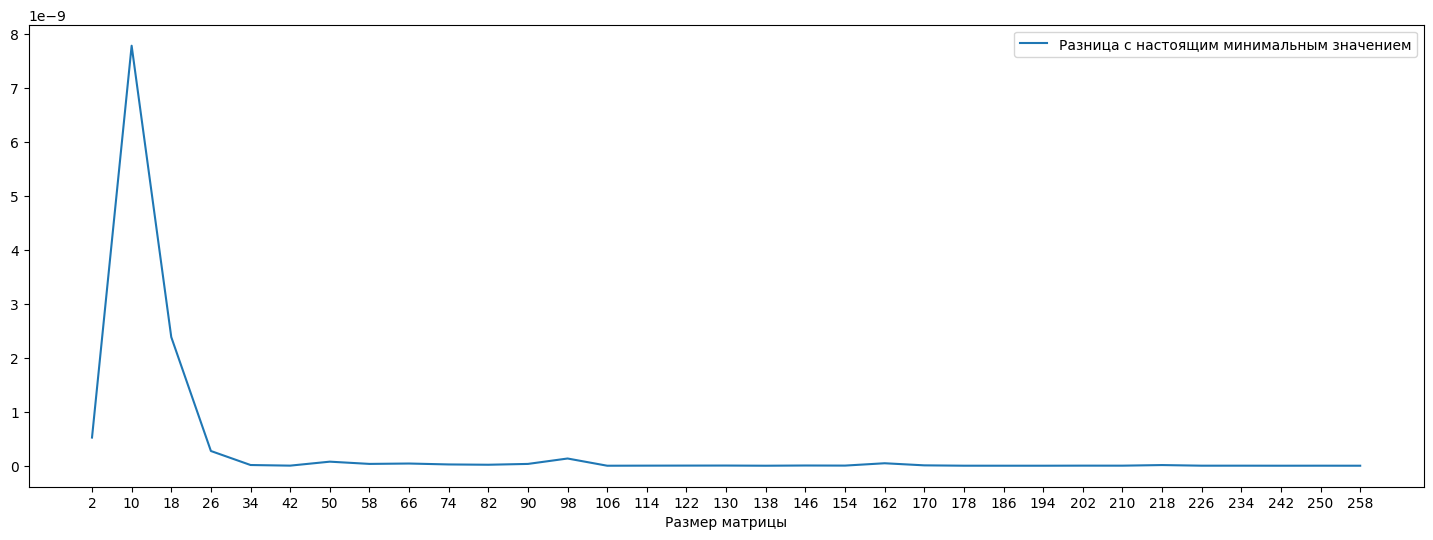

In [280]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_df["delta_min_def"], label="Разница с настоящим минимальным значением")
plt.legend()

plt.savefig('img/diff_min.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

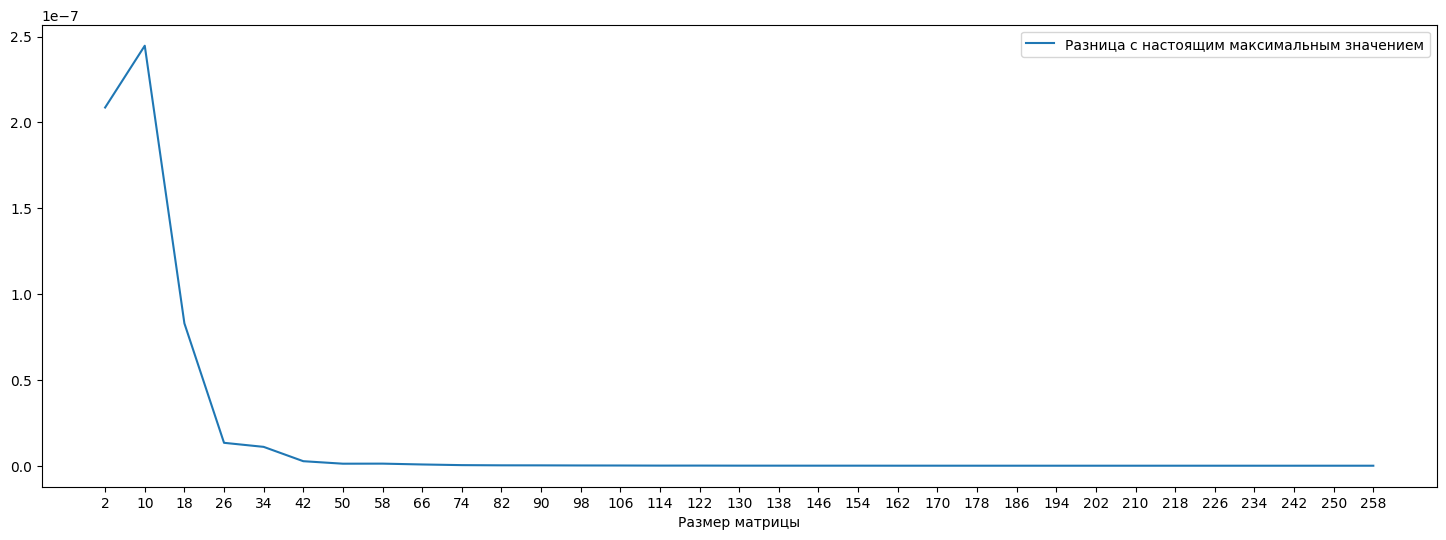

In [281]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_df["delta_max"], label="Разница с настоящим максимальным значением")
plt.legend()

plt.savefig('img/diff_max.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

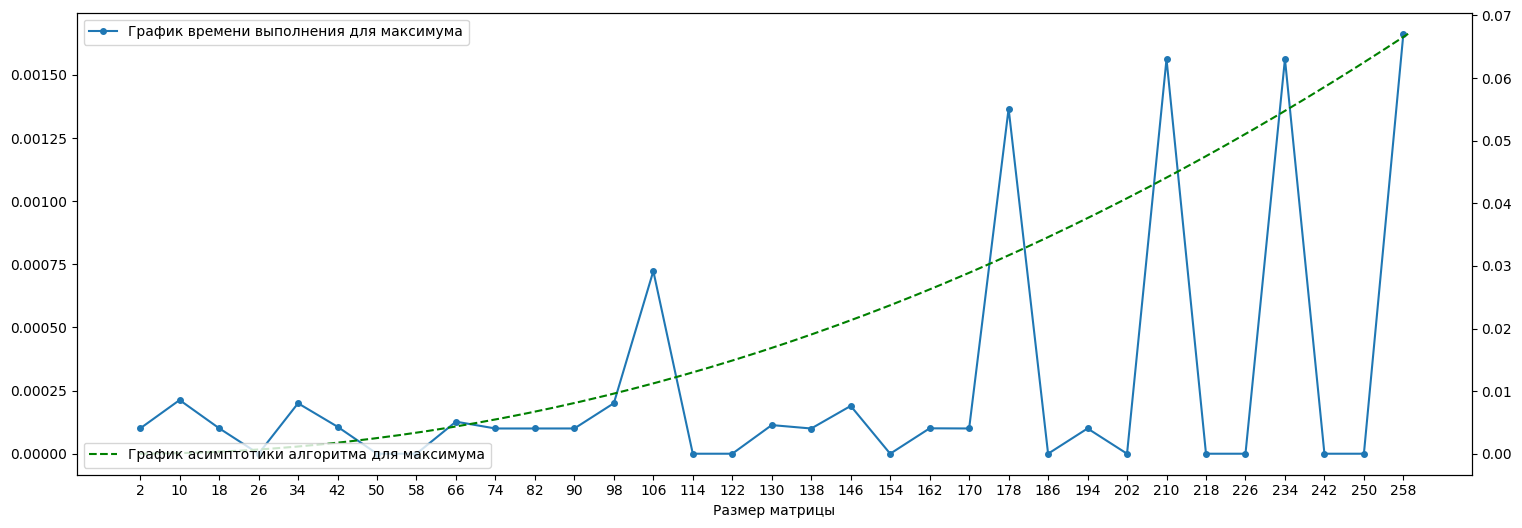

In [282]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_df["value_max_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для максимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**2) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для максимума",
)

ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_max.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

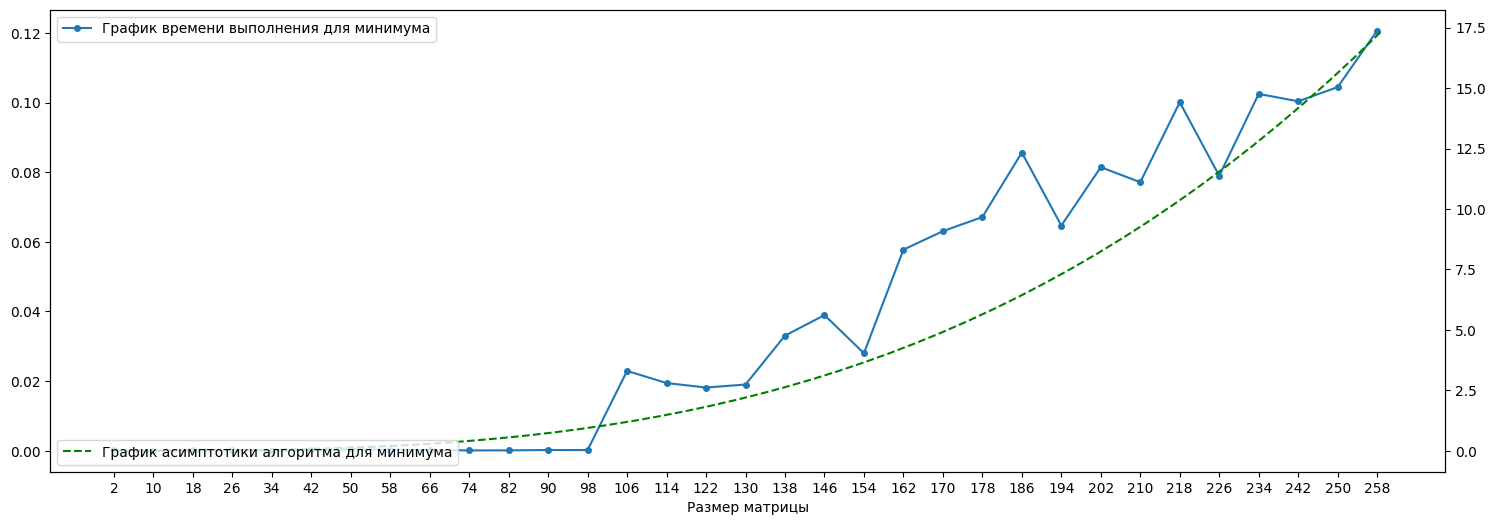

In [283]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_df["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)


ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_min.png', dpi=300, bbox_inches='tight')
plt.show()

# Дополнительная часть

## Вычисление

In [284]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
funcs_names = ["Прямые итерации", "Обратные итерации (обычные)"]
funcs = [power_iteration, inverse_power_def]

In [286]:
for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # Пришлось ввести симметричную матрицу из-за комплексных корней
        df.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(A=matr, funcs_names=funcs_names, funcs=funcs, is_numpy=True)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:10
1
2
3
4
5
6
7
8
9
10

Current size:18
1
2
3
4
5
6
7
8
9
10

Current size:26
1
2
3
4
5
6
7
8
9
10

Current size:34
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:50
1
2
3
4
5
6
7
8
9
10

Current size:58
1
2
3
4
5
6
7
8
9
10

Current size:66
1
2
3
4
5
6
7
8
9
10

Current size:74
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:90
1
2
3
4
5
6
7
8
9
10

Current size:98
1
2
3
4
5
6
7
8
9
10

Current size:106
1
2
3
4
5
6
7
8
9
10

Current size:114
1
2
3
4
5
6
7
8
9
10

Current size:122
1
2
3
4
5
6
7
8
9
10

Current size:130
1
2
3
4
5
6
7
8
9
10

Current size:138
1
2
3
4
5
6
7
8
9
10

Current size:146
1
2
3
4
5
6
7
8
9
10

Current size:154
1
2
3
4
5
6
7
8
9
10

Current size:162
1
2
3
4
5
6
7
8
9
10

Current size:170
1
2
3
4
5
6
7
8
9
10

Current size:178
1
2
3
4
5
6
7
8
9
10

Current size:186
1
2
3
4
5
6
7
8
9
10

Current size:194
1
2
3
4
5
6
7
8
9
10

Current size:202
1
2
3
4
5
6
7
8
9
10



,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,0.129981,0.011436,0.129981,0.0,0.011436,0.0,0.0,0.0
2,2,0.785361,0.000782,0.785361,0.0,0.000782,0.0,0.0,0.0
3,2,1.29516,0.008192,1.29516,0.0,0.008192,0.0,0.0,0.0
4,2,1.740418,0.039289,1.740418,0.0,0.039289,0.0,0.0,0.0
5,2,0.768589,0.036827,0.768589,0.0,0.036827,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
326,258,16662.190811,0.00083,16662.190811,0.0,0.00083,0.085883,0.0,0.0
327,258,16668.793562,0.000034,16668.793562,0.0,0.000034,0.117881,0.0,0.0
328,258,16778.066417,0.000073,16778.066417,0.0,0.000073,0.078524,0.0,0.0
329,258,16703.310296,0.000082,16703.310296,0.0,0.000082,0.216897,0.0,0.0


In [287]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def"]]

mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def
size,,,,
2,0.0,0.0,0.000001,0.0
10,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0
50,0.0002,0.0001,0.0,0.0
58,0.000203,0.000488,0.0,0.0
66,0.0001,0.0,0.0,0.0


<Figure size 1800x600 with 0 Axes>

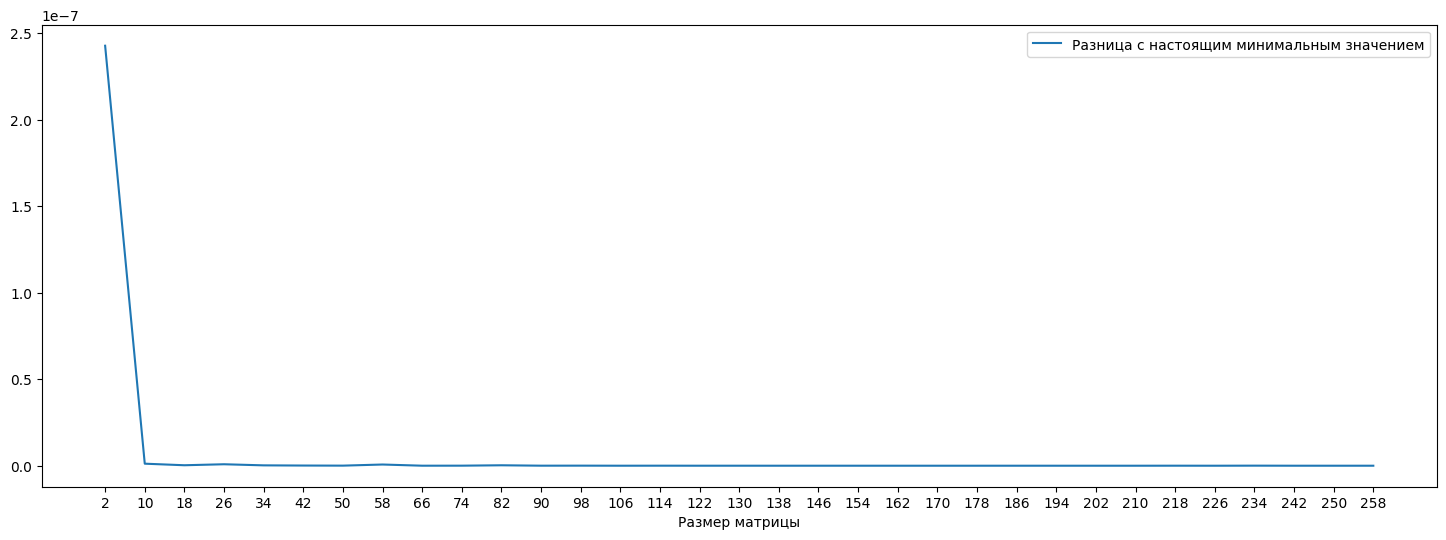

In [288]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_df["delta_min_def"], label="Разница с настоящим минимальным значением")
plt.legend()

plt.savefig('img/diff_min_numpy.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

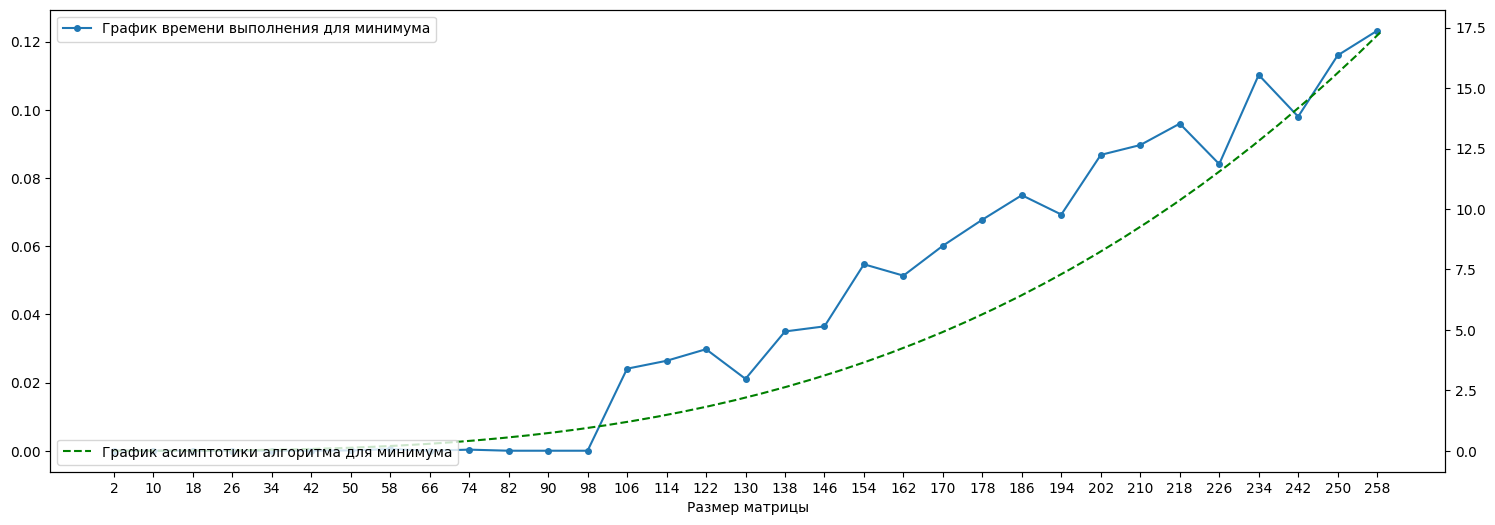

In [289]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_df["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)


ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_min_numpy.png', dpi=300, bbox_inches='tight')
plt.show()